In [ ]:
#Pre setup
# Download pre-trained FaceNet model that will be used for image embedding process
import os

if not os.path.exists('facenet_keras.h5'):
    ! wget https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5
try:
    import mtcnn
except ModuleNotFoundError:
    ! pip install mtcnn

try:
    import split_folders
except ModuleNotFoundError:
    ! pip install split-folders

--2023-09-16 17:05:16--  https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/D2KLab/FaceRec/raw/master/model/facenet_keras.h5 [following]
--2023-09-16 17:05:16--  https://github.com/D2KLab/FaceRec/raw/master/model/facenet_keras.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/D2KLab/FaceRec/master/model/facenet_keras.h5 [following]
--2023-09-16 17:05:17--  https://raw.githubusercontent.com/D2KLab/FaceRec/master/model/facenet_keras.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... con

In [ ]:
#Import all the libs needed
import mtcnn
import numpy as np
import os
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model

In [ ]:
# Preparing kaggle environment to download the dataset. For a reference of how to get kaggle.json, please see https://www.kaggle.com/general/74235
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anoushah","key":"90914b43537c7c010124ec1a2918890a"}'}

In [ ]:
!pip install split-folders

In [ ]:
# Download and split the dataset into train/val dataset
# The data set source https://www.kaggle.com/hereisburak/pins-face-recognition

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d hereisburak/pins-face-recognition
! unzip -q pins-face-recognition.zip

import split_folders
training_examples = 20
validation_examples = 7
collection_dir = 'pins_dataset'

split_folders.fixed(input='105_classes_pins_dataset', output=collection_dir, fixed=(training_examples, validation_examples))

mkdir: cannot create directory ‘/root/.kaggle’: File exists
pins-face-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
replace 105_classes_pins_dataset/pins_Adriana Lima/Adriana Lima0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

ModuleNotFoundError: ignored

## Face Detection
Purpose for this cell is to get a face only dataset from the given dataset, to be able to be used in face embedding process. The faces extracted will save all the detected face to faces-only-dataset.npz format

In [ ]:
import time

def extract_face(filename, required_size=(160,160)):
    detector = MTCNN()
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    faces = detector.detect_faces(pixels)

    face_array = None
    if len(faces) > 0:
      initialX, initialY, initialWidth, initialHeight = faces[0]['box']
      used_index = 0
      highestWidth = initialX
      highestHeight = initialY
      index = 0
      for face in faces:
      #With Assumption that we're going to close up the targetted person
          x, y, width, height = face['box']
          if width > highestWidth or height > highestHeight :
              used_index = index
              break

          index = index + 1

      x1, y1, width, height = faces[used_index]['box']
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      face_boundary = pixels[y1:y2, x1:x2]
      face_image = Image.fromarray(face_boundary)
      face_image = face_image.resize(required_size)
      face_array = asarray(face_image)
      # print(used_index)
      return face_array
    else:
      print(f'{filename} face cannot be detected')
      plt.imshow(image)
      plt.show()
    return face_array

def load_faces(directory):
    faces = []
    for filename in os.listdir(directory):
      path = os.path.join(directory, filename)
      face = extract_face(path)
      if face is not None:
        faces.append(face)
    return faces

def load_dataset(directory):
    x, y = [], []
    counter = 1
    start_time = time.time()
    for subdir in os.listdir(directory):
      mid_time = time.time()
      path = os.path.join(directory, subdir + '/') # e.g: train/ben_afflect/
      print(f'processing {path} ({counter} out of {len(os.listdir(directory))})...')
      faces = load_faces(path)
      labels = [subdir for i in range(len(faces))] # assign label to each face
      x.extend(faces)
      y.extend(labels)
      print('>loaded %d examples for class %s in %d seconds.' % (len(faces), subdir, time.time() - mid_time))
      counter += 1
    end_time = time.time()
    print(f'Finish processing {directory} for {end_time - start_time} seconds.')
    return asarray(x), asarray(y)

train_dir = os.path.join(collection_dir, 'val')
train_X, train_y = load_dataset(train_dir)
print(train_X.shape, train_y.shape)
val_dir = os.path.join(collection_dir, 'test')
val_X, val_y = load_dataset(val_dir)
print(val_X.shape, val_y.shape)
np.savez_compressed('faces-only-dataset.npz', train_X, train_y, val_X, val_y)

#Create Embedding for Each Face
From the face generated earlier, we create an embedding of the face using FaceNet

In [ ]:
import time

data = np.load('faces-only-dataset.npz')
train_X, train_y = data['arr_0'], data['arr_1']
test_X, test_y = data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (train_X.shape[0], test_X.shape[0]))
print('Loaded: ', train_X.shape, train_y.shape, test_X.shape, test_y.shape)

model = load_model('facenet_keras.h5')
print('Loaded Model')

def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis=0)
    y_hat = model.predict(samples) # get the embedding
    return y_hat

start = time.time()
new_train_X = list()
for face_pixels in train_X:
	embedding = get_embedding(model, face_pixels)
	new_train_X.extend(embedding)

new_train_X = asarray(new_train_X)
print(new_train_X.shape)

new_test_X = list()
for face_pixels in test_X:
	embedding = get_embedding(model, face_pixels)
	new_test_X.extend(embedding)
new_test_X = asarray(new_test_X)

print(new_test_X.shape)
end = time.time()
print(f'End processing for {end - start} seconds')

np.savez_compressed('faces-embeddings.npz', new_train_X, train_y, new_test_X, test_y)

## Performing Faces Classification

From the embedding, we perform the face classification using SVM model and the embedding as the feature. The target is the face classes (whom the face is)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

data = np.load('faces-embeddings.npz')
train_X, train_y = data['arr_0'], data['arr_1']
test_X, test_y = data['arr_2'], data['arr_3']

encoder = LabelEncoder()
encoder.fit(train_y)

label_classes = encoder.classes_
train_y_encoded = encoder.transform(train_y)
test_y_encoded = encoder.transform(test_y)

# define the keras model
model_vector_classifier = Sequential()
model_vector_classifier.add(Dense(64, input_dim=128, activation='relu'))
model_vector_classifier.add(Dense(32, activation='relu'))
model_vector_classifier.add(Dense(105, activation='softmax'))
model_vector_classifier.summary()

model_vector_classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_vector_classifier.fit(train_X, train_y_encoded, epochs=15, batch_size=10, verbose=0)

_, score_train = model_vector_classifier.evaluate(train_X, train_y_encoded)
_, score_test = model_vector_classifier.evaluate(test_X, test_y_encoded)


print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26271 (Dense)          (None, 64)                8256      
_________________________________________________________________
dense_26272 (Dense)          (None, 32)                2080      
_________________________________________________________________
dense_26273 (Dense)          (None, 105)               3465      
Total params: 13,801
Trainable params: 13,801
Non-trainable params: 0
_________________________________________________________________
735/735 [==============================] - 0s 58us/step
Accuracy: train=100.000, test=92.925


In [ ]:
def top_10_prediction(prob, labels):
    sorted_rank = (-prob).argsort()[:10]
    label_prob = {}
    counter = 0
    for index in sorted_rank:
        class_ = labels[index]
        probability = prob[index]
        label_prob[class_.replace(' ', '_')] = probability*100
        counter += 1

    s = sorted(label_prob.items(), key=lambda x: x[1], reverse=True)[:10]
    for k, v in s:
        print(k.replace('pins_', '').replace('_', ' '), f'{v:.2f}%')

Predicted: pins_Leonardo DiCaprio (89.577)
Expected: pins_Leonardo DiCaprio


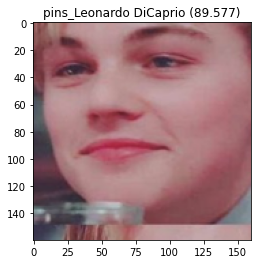

Leonardo DiCaprio 89.58%
Logan Lerman 5.57%
Tom Hardy 3.54%
Tom Holland 1.15%
Johnny Depp 0.09%
Selena Gomez 0.04%
grant gustin 0.01%
Marie Avgeropoulos 0.01%
Lili Reinhart 0.01%
Ben Affleck 0.00%


In [ ]:
# test model on a random example from the test dataset
import random
data = np.load('faces-only-dataset.npz')
test_X_faces = data['arr_2']

selection = random.choice([i for i in range(test_X.shape[0])])
random_face_pixels = test_X_faces[selection]
random_face_emb = test_X[selection]
random_face_class = test_y_encoded[selection]
random_face_name = encoder.inverse_transform([random_face_class])
# prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model_vector_classifier.predict_classes(samples)
yhat_prob = model_vector_classifier.predict(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
plt.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
top_10_prediction(yhat_prob[0], encoder.classes_)

## Export the Model

Export the model to be used in other environment

In [ ]:
import json
model_vector_classifier.save('vector_classifier.h5')
with open('label_classes.json', 'w') as outfile:
    json.dump(list(encoder.classes_), outfile)

## Using Pretrained Model from Code Above

In [ ]:
def setup():
    # Download pre-trained FaceNet model, pre-trained SVM, and photo labels
    import os

    if not os.path.exists('facenet_keras.h5'):
        !wget https://github.com/D2KLab/Face-Celebrity-Recognition/raw/master/model/facenet_keras.h5
    if not os.path.exists('label_classes.json'):
        !wget https://ibam.imfast.io/label_classes.json
    if not os.path.exists('vector_classifier.h5'):
        !wget https://ibam.imfast.io/vector_classifier.h5

    # install mtcnn
    try:
        import mtcnn
    except ModuleNotFoundError:
        !pip install mtcnn

def get_pre_trained():
    import json
    import numpy as np
    from keras.models import load_model

    face_classes = json.load(open('label_classes.json'))
    model_vector_classifier = load_model('vector_classifier.h5')
    model_facenet = load_model('facenet_keras.h5')
    return model_facenet, model_vector_classifier, face_classes

def extract_face(filename, required_size=(160,160)):
    from mtcnn.mtcnn import MTCNN
    from numpy import asarray
    from PIL import Image
    from matplotlib import pyplot as plt

    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    # detect face
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    # bounding box
    x1, y1, width, height = results[0]['box'] # assuming the photo only contains one face
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    plt.imshow(face)
    plt.show()

    return face_array

def get_embedding(model, face_pixels):
    import numpy as np

    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis=0)
    y_hat = model.predict(samples) # get the embedding
    return y_hat

def predict_face(model_facenet, model_vector_classifier, face_classes):
    from google.colab import files

    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    face_pixels = extract_face(file_name)
    embedding = get_embedding(model_facenet, face_pixels)

    predicted_class = model_vector_classifier.predict_classes(embedding)
    probability = model_vector_classifier.predict(embedding)[0]
    predicted_name = face_classes[predicted_class[0]]
    print(f'Predicted {predicted_name} with probabilty {probability[predicted_class[0]]*100:.2f}%')
    top_10_prediction(probability, face_classes)

def top_10_prediction(prob, labels):
    sorted_rank = (-prob).argsort()[:10]
    label_prob = {}
    counter = 0
    for index in sorted_rank:
        class_ = labels[index]
        probability = prob[index]
        label_prob[class_.replace(' ', '_')] = probability*100
        counter += 1

    s = sorted(label_prob.items(), key=lambda x: x[1], reverse=True)[:10]
    print('\nTop 10 Predicted Classes:')
    for k, v in s:
        print(k.replace('pins_', '').replace('_', ' '), f'{v:.2f}%')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Saving messi.jfif to messi (3).jfif


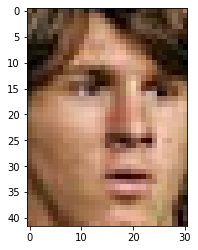

Predicted pins_Lionel Messi with probabilty 74.25%

Top 10 Predicted Classes:
Lionel Messi 74.25%
Tom Cruise 10.53%
Mark Zuckerberg 3.11%
Jake Mcdorman 2.69%
Andy Samberg 1.65%
Jeremy Renner 1.61%
Taylor Swift 0.78%
Maria Pedraza 0.70%
Ben Affleck 0.69%
Tom Holland 0.68%


In [ ]:
setup()
model_facenet, model_vector_classifier, face_classes = get_pre_trained()
predict_face(model_facenet, model_vector_classifier, face_classes)